In [ ]:
! pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from numpy.random import normal
from numpy.linalg import inv
from scipy.signal import cont2discrete
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample

from kan import KAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import sympy
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SUMMER_RESEARCH/Data/wmean.csv')

In [ ]:
X = data.drop(columns=['target_depression', 'target_anxiety', 'target_sleep'])
y = data[['target_depression']].astype(int)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

In [ ]:
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long).squeeze()

val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long).squeeze()

test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_input)
X_val_scaled = scaler.transform(val_input)
X_test_scaled = scaler.transform(test_input)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

In [ ]:
dataset = {
    'train_input': X_train_scaled,
    'train_label': train_label,

    'val_input': X_val_scaled,
    'val_label': val_label,

    'test_input': X_test_scaled,
    'test_label': test_label
}

In [ ]:
dataset['train_input'] = X_train_scaled.clone().detach().requires_grad_(True)
dataset['val_input'] = X_val_scaled.clone().detach()
dataset['test_input'] = X_test_scaled.clone().detach()

dataset['train_label'] = train_label.reshape(-1, 1).detach().clone().float().to(device)
dataset['val_label'] = val_label.reshape(-1, 1).detach().clone().float().to(device)
dataset['test_label'] = test_label.reshape(-1, 1).detach().clone().float().to(device)


print("=======================================")
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print('---------------------------------------')
print("Val data shape: {}".format(dataset['val_input'].shape))
print("Val target shape: {}".format(dataset['val_label'].shape))
print("====================================")

Train data shape: torch.Size([1008, 26])
Train target shape: torch.Size([1008, 1])
---------------------------------------
Val data shape: torch.Size([126, 26])
Val target shape: torch.Size([126, 1])


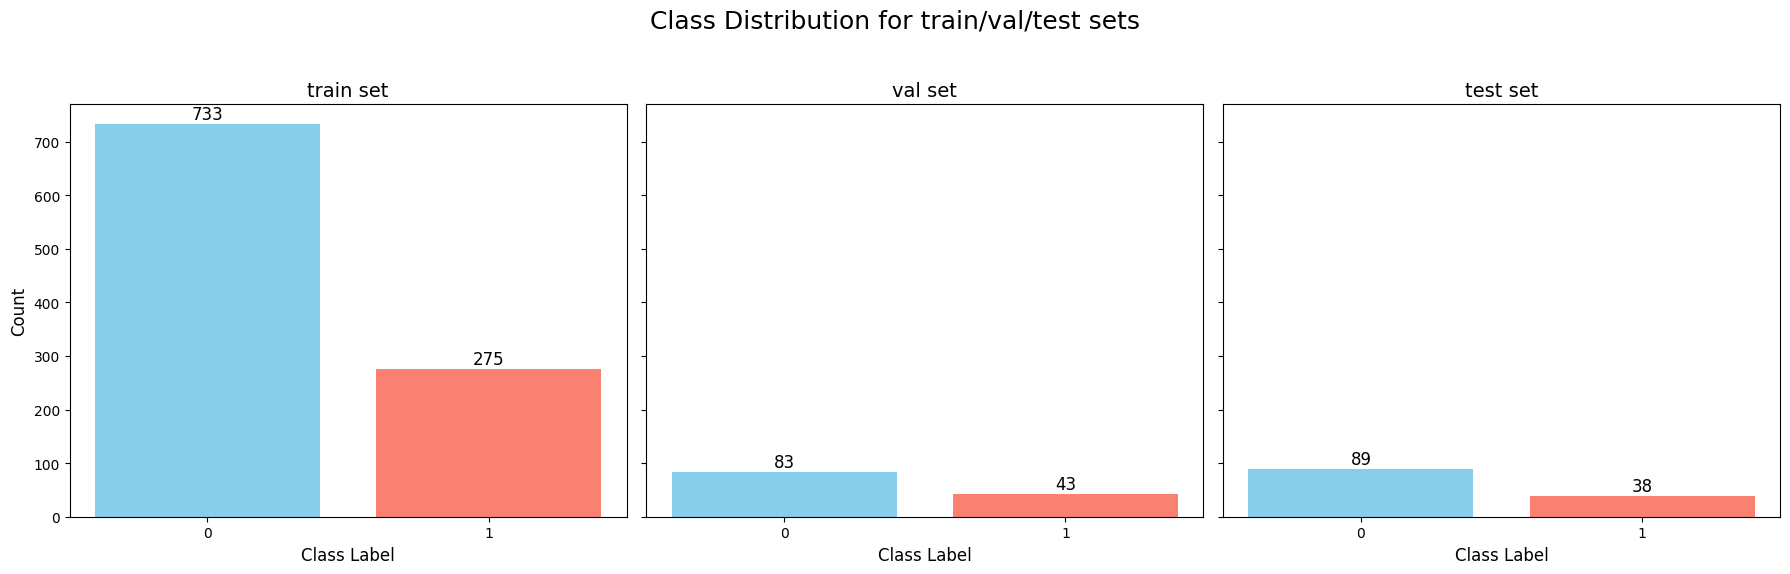

In [ ]:
labels = train_label, val_label, test_label
sets = ['train', 'val', 'test']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Class Distribution for train/val/test sets', fontsize=18)

for i, set_name in enumerate(sets):
    counts = np.bincount(labels[i])
    bars = axes[i].bar(['0', '1'], counts, color=['skyblue', 'salmon'])

    # Annotate counts on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height + 2, str(count),
                     ha='center', va='bottom', fontsize=12)

    axes[i].set_title(f'{set_name} set', fontsize=14)
    axes[i].set_xlabel('Class Label', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
model = KAN(width=[dataset['train_input'].shape[1], 53, 1], grid=5, k=3, seed=23, device=device)

model(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0


tensor([[ 0.4557],
        [-0.0051],
        [-0.0468],
        ...,
        [ 0.0122],
        [-0.0387],
        [ 0.1873]], grad_fn=<AddBackward0>)

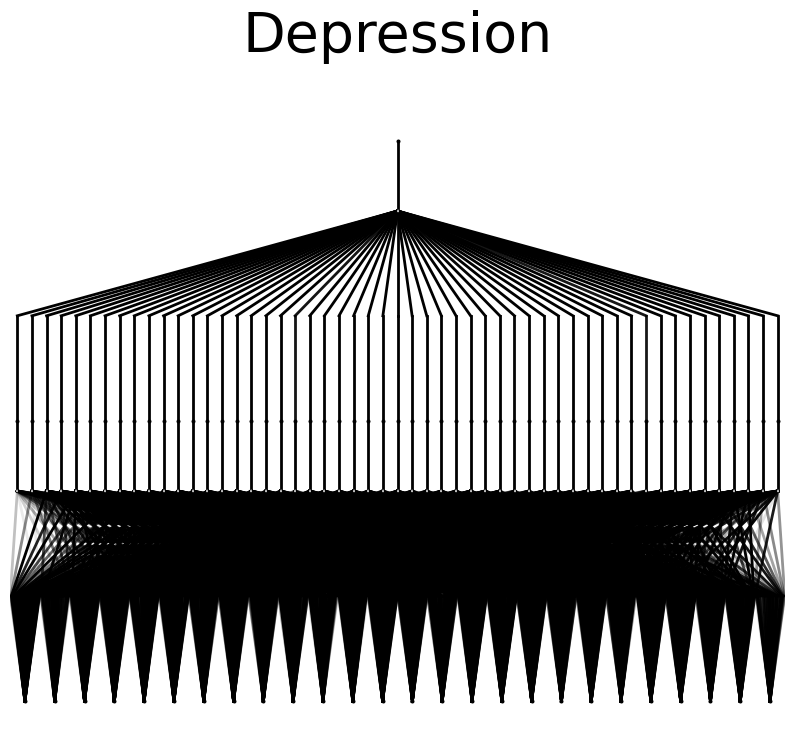

In [ ]:
model.plot(beta=100, scale=1 , out_vars=['Depression'])

In [ ]:
# for BCEwithlogitsloss pos_weight
def compute_pos_weight(y):
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    return torch.tensor([neg / pos], dtype=torch.float32)

# for getting accuracy in training
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def val_acc():
    return torch.mean((torch.argmax(model(dataset['val_input']), dim=1) == dataset['val_label']).float())

pos_weight = compute_pos_weight(y_train)

Optimizer = "LBFGS"
Criteron = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/tmp/ipython-input-994307020.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor([neg / pos], dtype=torch.float32)


# TRAINING ROUND 1

In [ ]:
results = model.fit(
    {'train_input': dataset['train_input'], 'train_label': dataset['train_label'], 'test_input': dataset['val_input'], 'test_label': dataset['val_label']},
    opt=Optimizer,
    metrics=(train_acc, val_acc),
    loss_fn=Criteron,
    steps=20,
    lamb=0.01
    )

| train_loss: 8.84e-01 | test_loss: 1.11e+00 | reg: 7.75e+00 | : 100%|█| 20/20 [06:40<00:00, 20.00s/


saving model version 0.1


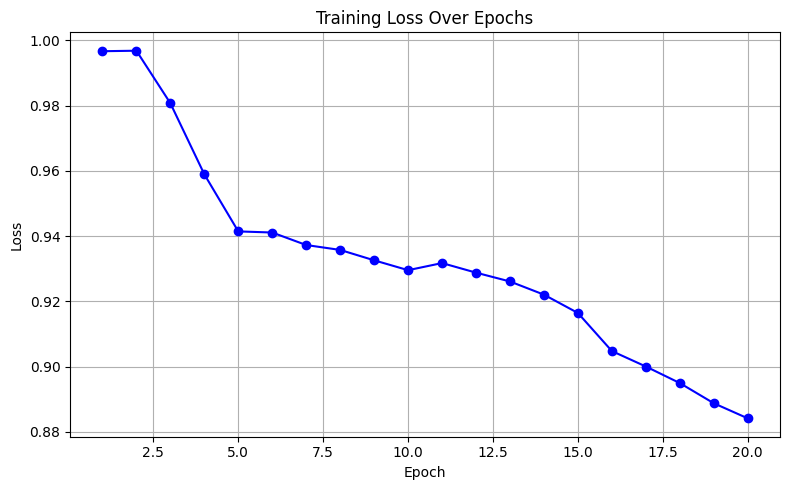

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20 + 1), results['train_loss'], marker='o', color='blue')
plt.title(f"Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Test Accuracy: 0.5354
Confusion Matrix:
[[49 40]
 [19 19]]
Balanced Accuracy: 0.5253
ROC AUC: 0.5189
PR AUC: 0.2910


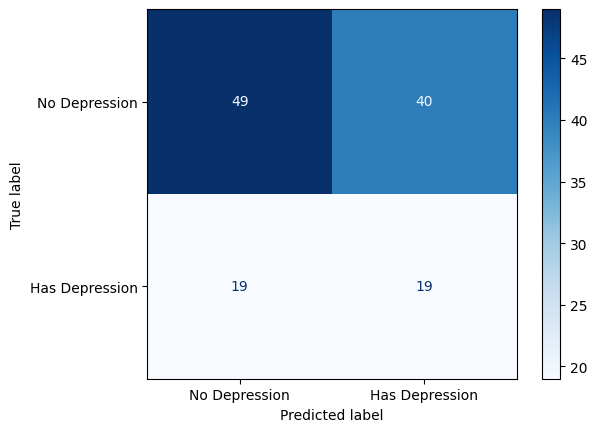

In [ ]:
y_test = dataset["test_label"].cpu().numpy().flatten()
y_pred_prob = torch.sigmoid(model(dataset["test_input"])).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Depression", "Has Depression"])
disp.plot(cmap="Blues")

metrics = {'Balanced Accuracy': 0, 'ROC AUC': 0, 'PR AUC': 0}
bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

metrics['Balanced Accuracy'] = bal_acc
metrics['ROC AUC'] = roc_auc
metrics['PR AUC'] = pr_auc

for metric, score in metrics.items():
  print(f'{metric}: {score:.4f}')


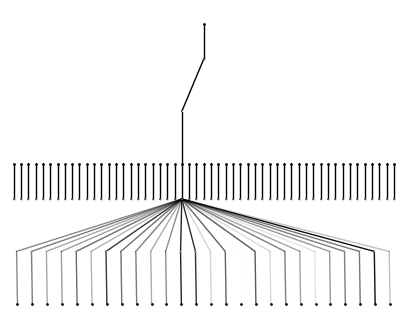

In [ ]:
model.plot()

In [ ]:
model_2 = model.prune()
model_2(dataset['train_input'])

saving model version 0.2


tensor([[ 0.9568],
        [ 1.1686],
        [ 1.2580],
        ...,
        [-1.7733],
        [ 0.8901],
        [ 1.3074]], grad_fn=<AddBackward0>)

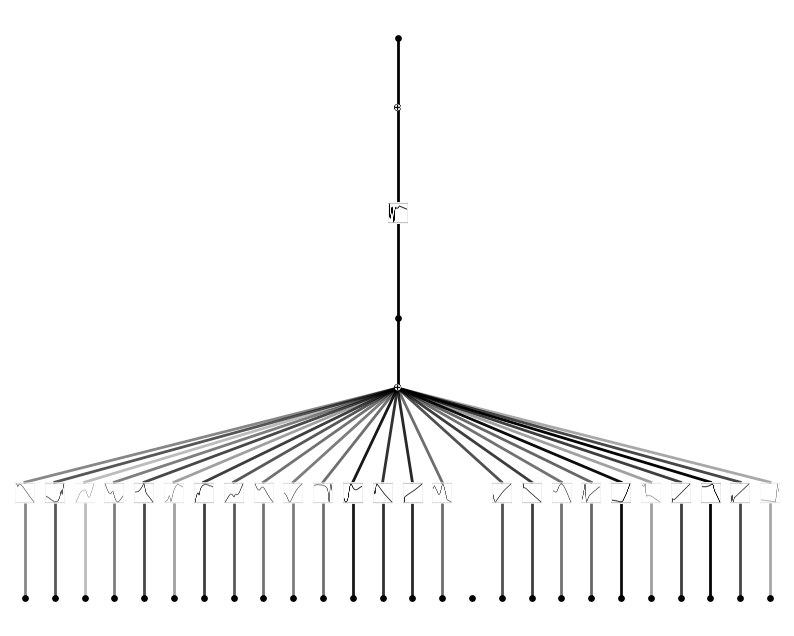

In [ ]:
model_2.plot(scale=1)

# TRAINING ROUND 2

In [ ]:
results_2 = model_2.fit(
    {'train_input': dataset['train_input'], 'train_label': dataset['train_label'], 'test_input': dataset['val_input'], 'test_label': dataset['val_label']},
    opt=Optimizer,
    metrics=(train_acc, val_acc),
    loss_fn=Criteron,
    steps=20
    )

| train_loss: 7.97e-01 | test_loss: 1.53e+00 | reg: 2.02e+01 | : 100%|█| 20/20 [02:53<00:00,  8.68s/

saving model version 0.3


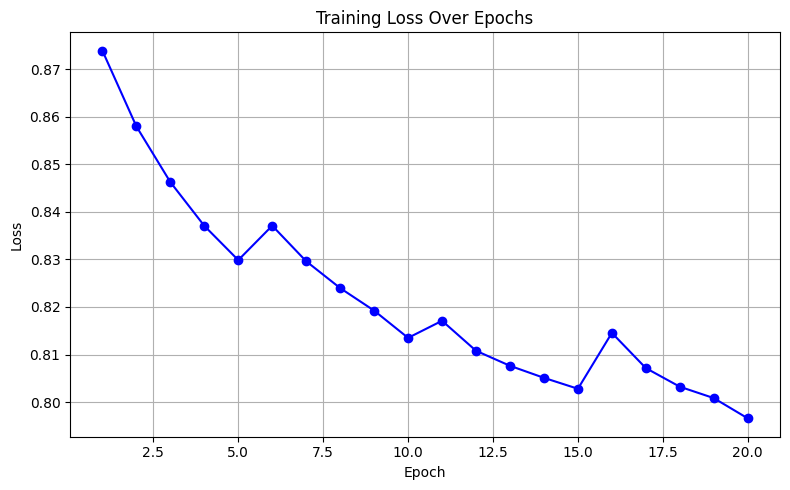

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20 + 1), results_2['train_loss'], marker='o', color='blue')
plt.title(f"Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Test Accuracy AFTER PRUNING: 0.5512
Confusion Matrix:
[[61 28]
 [29  9]]
Balanced Accuracy: 0.4611
ROC AUC: 0.5275
PR AUC: 0.3170


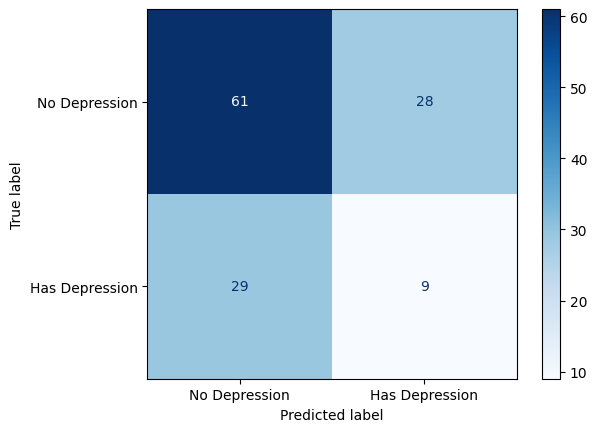

In [ ]:
y_test = dataset["test_label"].cpu().numpy().flatten()
y_pred_prob = torch.sigmoid(model_2(dataset["test_input"])).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.7).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy AFTER PRUNING: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Depression", "Has Depression"])
disp.plot(cmap="Blues")

metrics = {'Balanced Accuracy': 0, 'ROC AUC': 0, 'PR AUC': 0}
bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

metrics['Balanced Accuracy'] = bal_acc
metrics['ROC AUC'] = roc_auc
metrics['PR AUC'] = pr_auc

for metric, score in metrics.items():
  print(f'{metric}: {score:.4f}')

In [ ]:
model_3 = model_2.prune()
model_3(dataset['train_input'])

saving model version 0.4


tensor([[ 2.0143],
        [ 0.3856],
        [ 1.0950],
        ...,
        [-5.7352],
        [ 1.5822],
        [-0.1000]], grad_fn=<AddBackward0>)

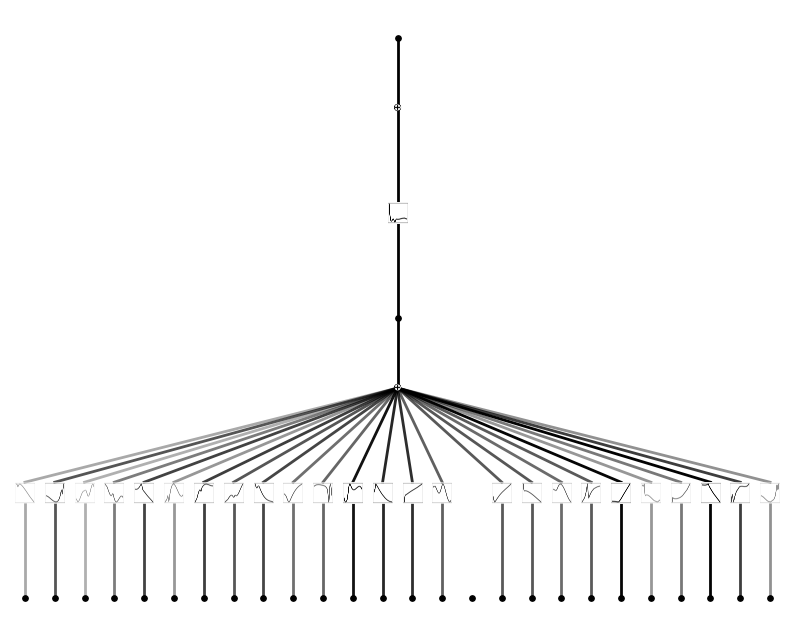

In [ ]:
model_3.plot(scale=1)

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']

model_3.auto_symbolic(lib=lib)
formula1 = model_3.symbolic_formula()[0]
print(formula1)

fixing (0,0,0) with 0
fixing (0,1,0) with x, r2=0.35301488637924194, c=1
fixing (0,2,0) with x, r2=0.7623764276504517, c=1
fixing (0,3,0) with x, r2=0.2062978297472, c=1
fixing (0,4,0) with x, r2=0.07822961360216141, c=1
fixing (0,5,0) with x, r2=0.6698516607284546, c=1
fixing (0,6,0) with x, r2=0.5440683364868164, c=1
fixing (0,7,0) with x, r2=0.9469076991081238, c=1
fixing (0,8,0) with x, r2=0.8636286854743958, c=1
fixing (0,9,0) with x, r2=0.12491737306118011, c=1
fixing (0,10,0) with x, r2=0.5668777823448181, c=1
fixing (0,11,0) with x, r2=0.8043457269668579, c=1
fixing (0,12,0) with 0
fixing (0,13,0) with x, r2=0.06285949051380157, c=1
fixing (0,14,0) with x, r2=0.16239704191684723, c=1
fixing (0,15,0) with x, r2=0.0527767688035965, c=1
fixing (0,16,0) with x, r2=0.854870080947876, c=1
fixing (0,17,0) with x, r2=0.023184897378087044, c=1
fixing (0,18,0) with x, r2=0.8774049282073975, c=1
fixing (0,19,0) with x, r2=0.9622398614883423, c=1
fixing (0,20,0) with x, r2=0.89297103881835

# symbolic formula

saving model version 0.7


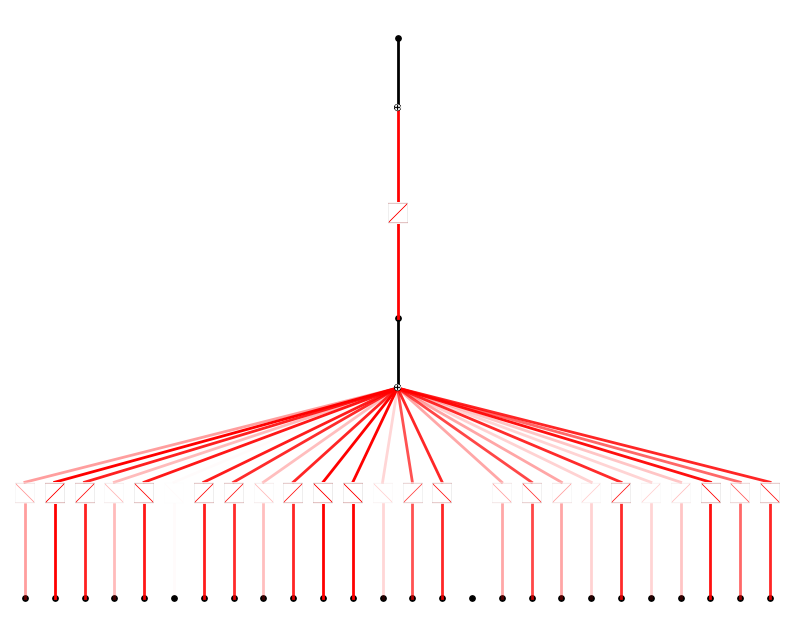

In [ ]:
model_3 = model_3.prune()
model_3.plot(scale=1)

In [ ]:
model_3.symbolic_formula()[0][0]

-0.0832850060272878*x_1 + 0.358034752026287*x_10 - 1.50311208873111*x_11 - 1.0363071710186*x_12 - 0.0388120345977207*x_13 + 0.135939172721734*x_14 - 0.327948577883734*x_15 - 0.0828537014549686*x_17 - 0.104899518833468*x_18 + 0.0948650411711729*x_19 + 2.05726713963499*x_2 + 0.0342351132045292*x_20 + 0.287218126758074*x_21 + 0.0449828594940522*x_22 + 0.0349608220896934*x_23 - 0.41224441860154*x_24 - 0.160445907444215*x_25 - 0.298023675019805*x_26 + 0.375204185554734*x_3 - 0.069693856806213*x_4 - 0.4199318930033*x_5 - 0.00520113975810976*x_6 + 0.337404464067937*x_7 + 0.306877944536505*x_8 - 0.0905708838988047*x_9 - 0.0894828960627549


Feature Ranking (Most Important First):
1. peakmins: 1.2585
2. peakcal: 1.0668
3. minsawake: 0.6332
4. sedentaryminutes: 0.5360
5. fatburnmins: 0.4957
6. minsasleep: 0.4707
7. bedtimedur: 0.4565
8. sdrate: 0.4265
9. fatburncal: 0.3119
10. timeoutofbed: 0.2814
11. lowrangecal: 0.2669
12. cardiomins: 0.2293
13. veryactiveminutes: 0.2134
14. minsafterwakeup: 0.1949
15. lightlyactiveminutes: 0.1894
16. date difference: 0.1464
17. cardiocal: 0.1421
18. floors: 0.1365
19. complypercent: 0.1333
20. timetobed: 0.1253
21. minstofallasleep: 0.1186
22. steps: 0.1164
23. meanrate: 0.1118
24. fairlyactiveminutes: 0.0988
25. Efficiency: 0.0000
26. lowrangemins: 0.0000

Top features for Depression (symbolic):
  peakmins: 1.0325
  minsawake: 0.6026
  fatburnmins: 0.5808
  peakcal: 0.5578
  sdrate: 0.4845


Evaluating symbolic formula on test set: 100%|██████████| 127/127 [00:03<00:00, 37.32it/s]



Depression (Single-task) — Symbolic Formula Performance
  Accuracy           : 0.6850
  Balanced Accuracy  : 0.5038
  ROC AUC            : 0.5231
  PR AUC             : 0.3402
----------------------------------------


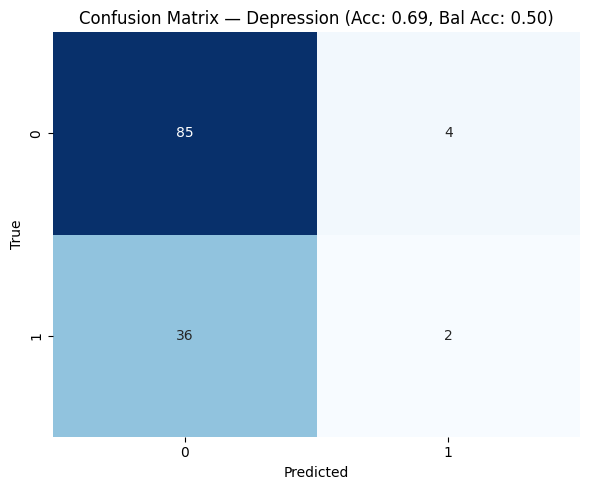

In [ ]:
import sympy

# --- Helpers ---

def as_sympy_expr(obj):
    """Return a single sympy.Expr from obj which may be an Expr, list/tuple (possibly nested), or string."""
    if isinstance(obj, sympy.Basic):
        return obj
    if isinstance(obj, (list, tuple)):
        for item in obj:
            try:
                expr = as_sympy_expr(item)
                if isinstance(expr, sympy.Basic):
                    return expr
            except Exception:
                continue
        raise TypeError("No sympy expression found inside the provided list/tuple.")
    if isinstance(obj, str):
        return sympy.sympify(obj)
    raise TypeError(f"Unsupported formula type: {type(obj)}")

def extract_feature_importance_sym(formula_expr, feature_names):
    """Rank features by summed |coeff| across additive terms containing them."""
    importance = {}
    # Expand to a sum of terms; handle general expressions safely
    try:
        expanded = sympy.expand(formula_expr)
    except Exception:
        expanded = formula_expr

    for term in sympy.Add.make_args(expanded):
        coeff, rest = term.as_coeff_Mul()
        try:
            c = float(coeff)
        except Exception:
            continue  # non-numeric coefficient; skip

        for v in rest.free_symbols:
            v_str = str(v)
            if v_str.startswith("x_"):
                try:
                    feat_idx = int(v_str.split("_")[1]) - 1
                except Exception:
                    continue
                if 0 <= feat_idx < len(feature_names):
                    fname = feature_names[feat_idx]
                    importance[fname] = importance.get(fname, 0.0) + abs(c)

    return sorted(importance.items(), key=lambda x: x[1], reverse=True)

def kan_symbolic_formula_prediction_test(formula_expr, X_np):
    """Evaluate a symbolic formula on X and return raw predictions (logit-like)."""
    preds = []
    x_symbols = [sympy.Symbol(f'x_{j+1}') for j in range(X_np.shape[1])]
    for i in tqdm(range(X_np.shape[0]), desc="Evaluating symbolic formula on test set"):
        subs = {x_symbols[j]: X_np[i, j] for j in range(X_np.shape[1])}
        val = formula_expr.subs(subs)
        preds.append(float(val.evalf()))
    return preds

feature_names = [col.split('_')[0] for col in list(X.columns)]
if len(feature_names) > 5:
    feature_names[5] = 'date difference'

formula1_expr = as_sympy_expr(formula1)

if hasattr(model_2, "feature_score"):
    fs = model_2.feature_score.detach().cpu().numpy().flatten()
    feature_ranking = sorted(zip(feature_names, fs), key=lambda x: x[1], reverse=True)
    print("\nFeature Ranking (Most Important First):")
    for i, (name, score) in enumerate(feature_ranking):
        print(f"{i+1}. {name}: {score:.4f}")

sorted_feats = extract_feature_importance_sym(formula1_expr, feature_names)
print("\nTop features for Depression (symbolic):")
for feat, score in sorted_feats[:5]:
    print(f"  {feat}: {score:.4f}")

X_test_np = dataset['test_input'].cpu().numpy()
preds_raw = kan_symbolic_formula_prediction_test(formula1_expr, X_test_np)
preds_sigmoid = torch.sigmoid(torch.tensor(preds_raw, dtype=torch.float32)).numpy().flatten()
preds_binary = (preds_sigmoid >= 0.5).astype(int)

y_true = dataset['test_label'].view(-1).cpu().numpy().astype(int)

acc = accuracy_score(y_true, preds_binary)
bal_acc = balanced_accuracy_score(y_true, preds_binary)
roc_auc = roc_auc_score(y_true, preds_sigmoid)
pr_auc = average_precision_score(y_true, preds_sigmoid)

print("\nDepression (Single-task) — Symbolic Formula Performance")
print(f"  Accuracy           : {acc:.4f}")
print(f"  Balanced Accuracy  : {bal_acc:.4f}")
print(f"  ROC AUC            : {roc_auc:.4f}")
print(f"  PR AUC             : {pr_auc:.4f}")
print("-" * 40)

cm = confusion_matrix(y_true, preds_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix — Depression (Acc: {acc:.2f}, Bal Acc: {bal_acc:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
